# Анализ мирового рынка видеоигр

## Задача
Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).  

Нужно выявить определяющие успешность игры закономерности, что позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.


### Цели анализа
В ходе работы над проектом необходимо найти взаимосвязи, которые помогли бы выявить наиболее успешные жанры и платформы для разработки игр в 2017-м году.


### Этапы работы над проектом

1. **Загрузка и предобработка данных**
    * Форматирование датасета
    * Обработка пропусков и дубликатов
    * Расчёт дополнительных значений
    

2. **Исследовательский анализ**
    * Визуализация динамики продаж
    * Расчёт и визуализация статистик
    * Поиск корелляций


3. **Анализ портретов пользователей**
    * Поиск популярных жанров по каждому региону
    * Поиск популярных платформ по каждому региону
    * Поиск взаимосвязи рейтинга ESRB с популярностью игр


4. **Проверка гипотез**


5. **Выводы по результатам анализа**
---

In [1]:
import pandas as pd
import numpy as np

from scipy import stats as st
from scipy.stats import binom

import matplotlib.pyplot as plt
import seaborn as sns

## Загрузка и подготовка данных

In [2]:
data = pd.read_csv('datasets/games.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### Общая информация
В датасете **16715** наблюдений, которые поделены на **11** признаков:
* `Name` — название игры
* `Platform` — платформа
* `Year_of_Release` — год выпуска
* `Genre` — жанр игры
* `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
* `EU_sales` — продажи в Европе (миллионы проданных копий)
* `JP_sales` — продажи в Японии (миллионы проданных копий)
* `Other_sales` — продажи в других странах (миллионы проданных копий)
* `Critic_Score` — оценка критиков (максимум 100)
* `User_Score` — оценка пользователей (максимум 10)
* `Rating` — рейтинг от организации ESRB

Названия столбцов набраны с заглавных букв, есть пропуски и несоответствие типов значений.

### Предобработка данных
#### Корректировка названий столбцов

In [3]:
data.columns = data.columns.str.lower()
list(data.columns)

['name',
 'platform',
 'year_of_release',
 'genre',
 'na_sales',
 'eu_sales',
 'jp_sales',
 'other_sales',
 'critic_score',
 'user_score',
 'rating']

Преобразование проведено успешно.

#### Поиск дубликатов

In [4]:
data.duplicated().sum()

0

Проверим датасет на наличие неявных дубликатов:

In [5]:
data[data[['name', 'platform','year_of_release']].duplicated(keep=False)].sort_values(by='name')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Нашлось две пары. Наблюдения отличаются значиенями в продажах по регионам, которые взаимно дополняют друг друга. Вероятно, они собирались из разных источников и не были объединены.

Так как пар всего две, вручную сложим значения в первых наблюдениях и отбросим вторые:

In [6]:
data.loc[604, 'eu_sales'] += 0.01
data.loc[659, 'jp_sales'] += 0.03

data.drop ([16230, 14244], inplace=True)

#### Обработка пропусков

In [7]:
data.isna().sum()

name                  1
platform              0
year_of_release     269
genre                 1
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8577
user_score         6700
rating             6765
dtype: int64

Визуализируем долю пропусков в каждом из столбцов:

In [8]:
pd.DataFrame(round(data.isna().mean().sort_values(ascending=False)*100,1)).style.background_gradient('coolwarm')

,0
critic_score,51.300000
rating,40.500000
user_score,40.100000
year_of_release,1.600000
name,0.000000
genre,0.000000
platform,0.000000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000


---
Для начала рассмотрим столбец `year_of_release`

In [9]:
data.loc[data['year_of_release'].isna()].head(3)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+


Так как у нас нет возможности достоверно заполнить все пропущенные значения, поступим так:
* Для столбца `year_of_release` попробуем найти год в столбце `name`, если это возможно. Например, в строке 183 значение `Madden NFL 2004` содежит год, который мы можем перенести. В остальных случаях заменим пропуски на `-1`
* В столбцах `critic_score` и `user_score` заменим пропуски на `-1`
* В столбцах `name`, `genre` и `rating` заменим пропуски на строку `'unknown'`

Такой подход поможет в будущем отфильтровать данные, в которых были пропуски. При этом, остальные столбцы в наблюдениях останутся нетронутыми.

In [10]:
# Парсинг 'year_of_release' из столбца 'name'
try:
    data['year_of_release'] = data['year_of_release'].fillna(data['name'].str.extract(r'(\d{4})', expand=False))
    data['year_of_release'] = data['year_of_release'].fillna(-1)
except:
    data['year_of_release'] = data['year_of_release'].fillna(-1)
    
# Проерка на примере 183 и 456 строк
data.loc[data.index.isin([183, 456])]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,2004,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
456,LEGO Batman: The Videogame,Wii,-1,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+


Парсинг сработал там, где это было возможно.

Продолжим обработку пропусков:

In [11]:
data[[ 'critic_score', 'user_score']] = data[[ 'critic_score', 'user_score']].fillna(-1)
data[['name', 'genre', 'rating']] = data[['name', 'genre', 'rating']].fillna('unknown')
data.isna().sum()

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

In [12]:
# Поиск значений 'tbd'
data.loc[data['user_score'] == 'tbd']['user_score'].count()

2424

В столбце `user_score` присутствуют 2424 значения `'tbd'`, что чаще всего в таком контексте означает "To Be Determined" — Будет Установлено. То есть, сейчас эти данные мы получить не сможем, поэтому обработаем их как пропуски.

Заменим `'tbd'` на `-1`:

In [13]:
data['user_score'] = data['user_score'].replace('tbd', -1)
data.loc[data['user_score'] == 'tbd']['user_score'].count()

0

В данных не осталось пропущенных значений. Продолжим предобработку.

#### Преобразование типов
* `year_of_release` имеет тип `float64`, в нём указан только год без месяца и дня. Приведём столбец к типу `int`. Так он будет занимать меньше памяти, а операции над ним будут произвоадиться эффективнее.
* `critic_score` иммет тип `float64`, несмотря на целочисленные значения с столбце. Приведём его к типу `int`
* `user_score` иммет тип `object`, хотя в нём находятся находятся числовые значения с десятичной частью. Приведём его к типу `float`

В остальных столбцах типы соответствуют значениям. Проедём преобразования:

In [14]:
data['year_of_release'] = data['year_of_release'].astype(int)
data['critic_score'] = data['critic_score'].astype(int)
data['user_score'] = data['user_score'].astype(float)

# Проверка
data.info()
data.head(2)

<class 'pandas.core.frame.DataFrame'>
Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16713 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     16713 non-null  int64  
 9   user_score       16713 non-null  float64
 10  rating           16713 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.5+ MB


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.0,unknown


Преобразование выполнено корректно.

### Расчёт дополнительных значений
#### Столбец «Суммарные продажи»
Суммируем проданные копии во всех регионах и занесём полученные значения в столбец `sum_sales`:

In [15]:
data['sum_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.head(2)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.0,unknown,40.24


Данные о суммарных продажах посчитаны корректно и добавлены в датасет.

### Итоги этапа
В результате предобработки данных удалось:
* Скорректировать названия столбцов
* Заполнить пропуски реальными данными и «заглушками»
* Сохранить все наблюдения в датасете

## Исследовательский анализ

### Cтатистика выпуска игр
Проанализироуем какое количество игр выпускалось каждый год.

Так как пропуски были заполнены с помощью `-1`, учтём это при визуализации, отфлильтровав значения:

In [16]:
# Выпущенные игры в каждом году с фильтрацией 
games_by_year = data.loc[data['year_of_release'] > 0]['year_of_release'].value_counts().sort_index()
print(f'Данные представлены в промежутке с {games_by_year.index.min()} по {games_by_year.index.max()} год.')

Данные представлены в промежутке с 1980 по 2016 год.


Построим столбчатую диаграмму и выведем статистики по отфильтрованным данным.

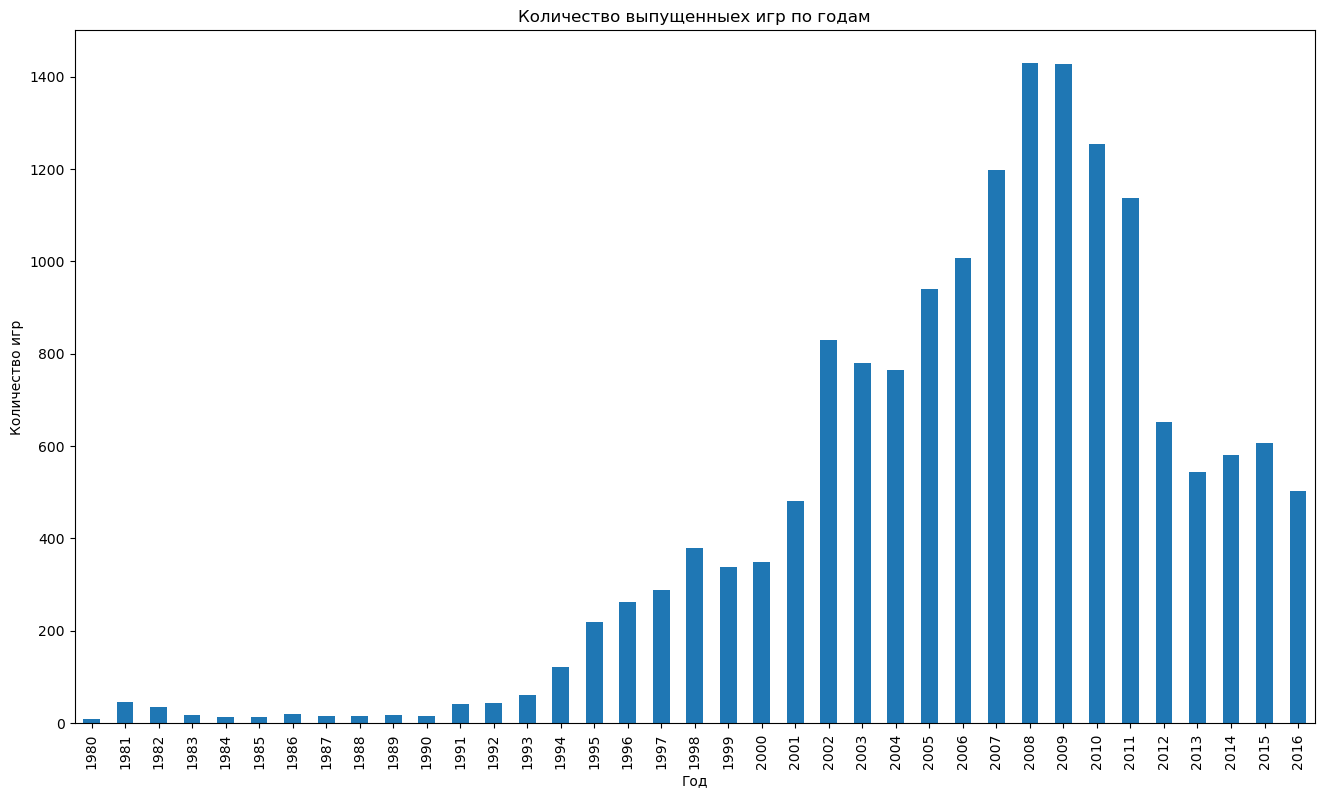

In [17]:
games_by_year.plot(kind='bar', figsize=(16, 9))

plt.title('Количество выпущенныех игр по годам')
plt.xlabel('Год')
plt.ylabel('Количество игр')
plt.show()

In [18]:
print(f'Максимальное количиество выпущенных игр за год: {games_by_year.max()}')

Максимальное количиество выпущенных игр за год: 1429


**Наблюдения**

Всю динамику можно разделить на 3 ключевых этапа:
1. **1980–1990** — стабильно низкий уровень выпуска игр
2. **1991—2008** — восходящий тренд c двумя коррекциями и пиком в 1429 игр в 2007 году
3. **2009—2016** — нисходящий тренд с одной коррекцией и вероятным началом второй в 2016 году

Наиболее значимыми для будущего анализа являются этапы 1 и 2 с 1991 по 2106 год, так как именно на них знаичтельно начала проявляться динамика рынка компьютерных игр.

Более узкие границы анализа мы очертим, когда исследуем жизненный цикл платформ.

---

### Изменение продаж по платформам

#### Наибольшие суммарные продажи
С помощью сводной таблицы сгруппируем данные по каждой платформе и определим тех, кто продал наибольшее число копий:

In [19]:
platforms_by_sales = data.pivot_table(index='platform',
                                      values='sum_sales',
                                      aggfunc=np.sum).\
sort_values(by='sum_sales', ascending=False).reset_index()
platforms_by_sales.head(7)

,platform,sum_sales
0,PS2,1255.77
1,X360,971.42
2,PS3,939.65
3,Wii,907.51
4,DS,806.12
5,PS,730.86
6,GBA,317.85


Разрыв между **PS** (index=5) и **GBA** (index=6) более чем в 2 раза, поэтому именно здесь мы проведём границу. Далее будем рассматривать первые 6 платформ.

Cсводная таблица распределения количества проданных копий по годам:

In [20]:
# Подготовка сводной таблицы для лидирующих платформ:
platforms_distribution = data[data['platform'].isin(platforms_by_sales.\
                                                    loc[lambda x: x.index.isin(range(0, 6)), 'platform'])] \
    .pivot_table(index=['platform', 'year_of_release'],
                 values=['sum_sales'],
                 aggfunc=np.sum)

# Удаление строк в которых год меньше 1991
platforms_distribution.drop(
    platforms_distribution[platforms_distribution.index.get_level_values(1) < 1991].index, inplace=True)

# year_of_release переводим из индекса в столбец
platforms_distribution.reset_index(level=1, inplace=True)

Построим графики для всех 6-ти лидеров рынка, чтобы проанализировать их жизненные циклы.

**1. PS2**

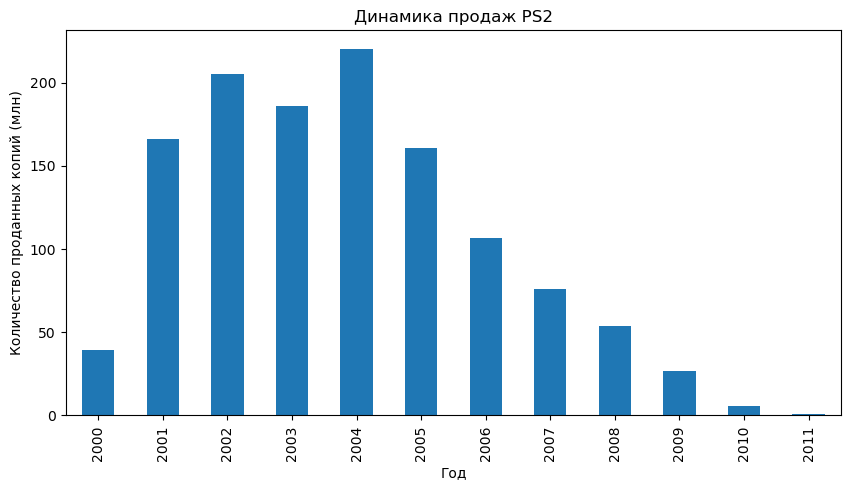

In [21]:
platforms_distribution.loc['PS2'].plot('year_of_release',
                                       kind = 'bar',
                                       figsize=(10, 5),
                                       legend=None)

plt.title('Динамика продаж PS2')
plt.xlabel('Год')
plt.ylabel('Количество проданных копий (млн)')
plt.show()

**2. X360**

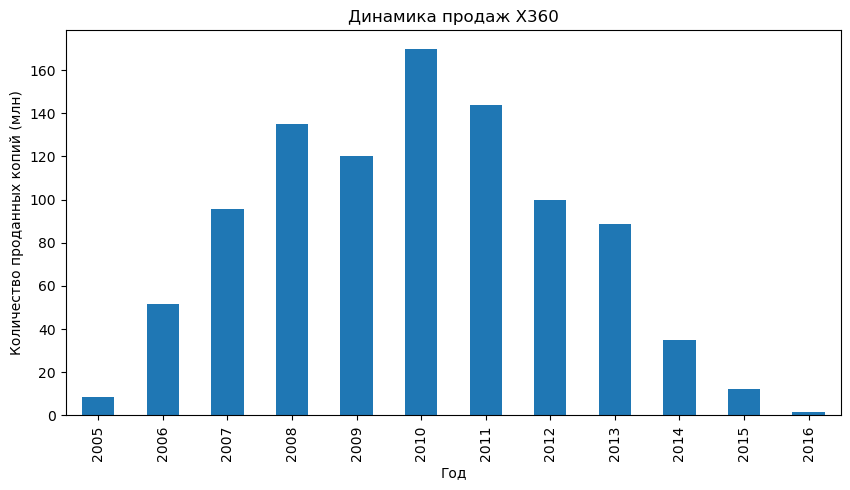

In [22]:
platforms_distribution.loc['X360'].plot('year_of_release',
                                       kind = 'bar',
                                       figsize=(10, 5),
                                       legend=None)
plt.title('Динамика продаж X360')
plt.xlabel('Год')
plt.ylabel('Количество проданных копий (млн)')
plt.show()

**3. PS3**

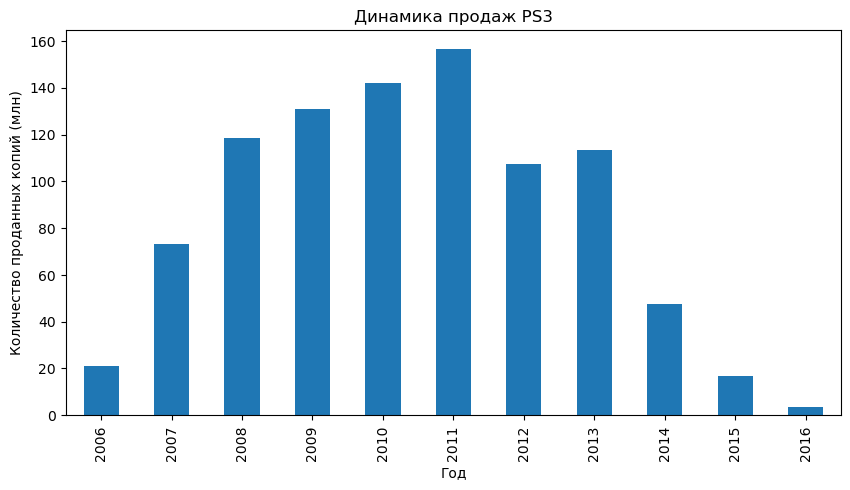

In [23]:
platforms_distribution.loc['PS3'].plot('year_of_release',
                                       kind = 'bar',
                                       figsize=(10, 5),
                                       legend=None)
plt.title('Динамика продаж PS3')
plt.xlabel('Год')
plt.ylabel('Количество проданных копий (млн)')
plt.show()

**4. Wii**

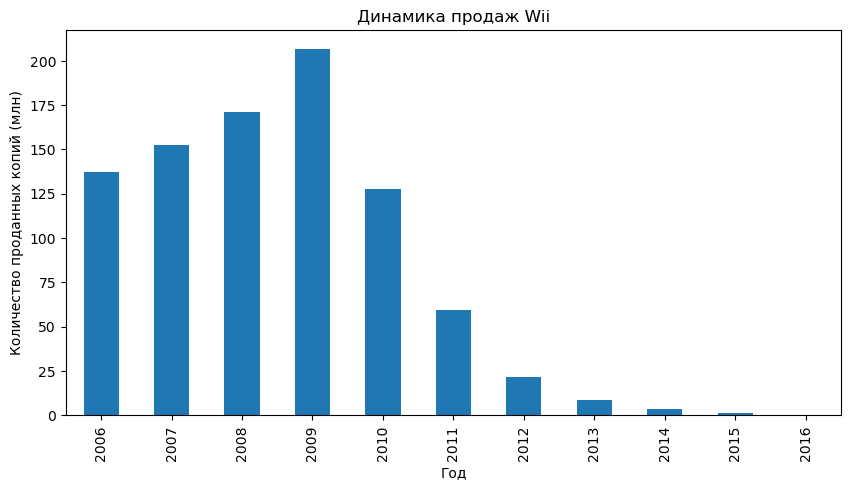

In [24]:
platforms_distribution.loc['Wii'].plot('year_of_release',
                                       kind = 'bar',
                                       figsize=(10, 5),
                                       legend=None)
plt.title('Динамика продаж Wii')
plt.xlabel('Год')
plt.ylabel('Количество проданных копий (млн)')
plt.show()

**5. DS**

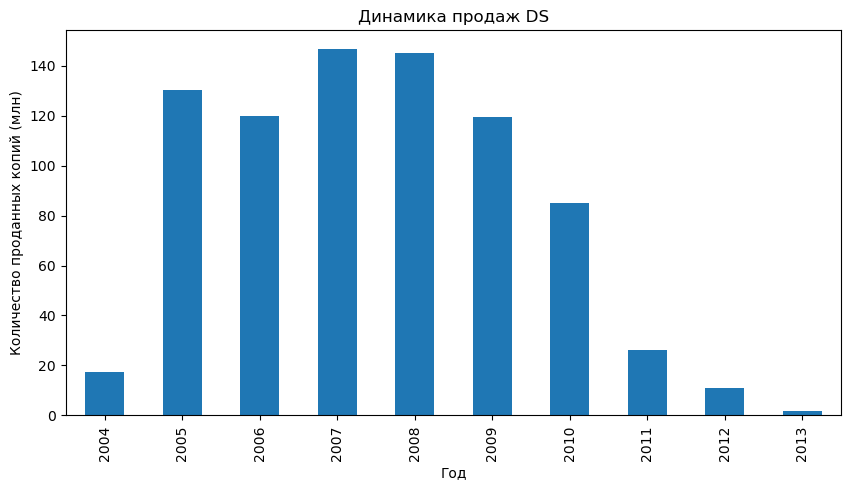

In [25]:
platforms_distribution.loc['DS'].plot('year_of_release',
                                       kind = 'bar',
                                       figsize=(10, 5),
                                       legend=None)
plt.title('Динамика продаж DS')
plt.xlabel('Год')
plt.ylabel('Количество проданных копий (млн)')
plt.show()

**6. PS**

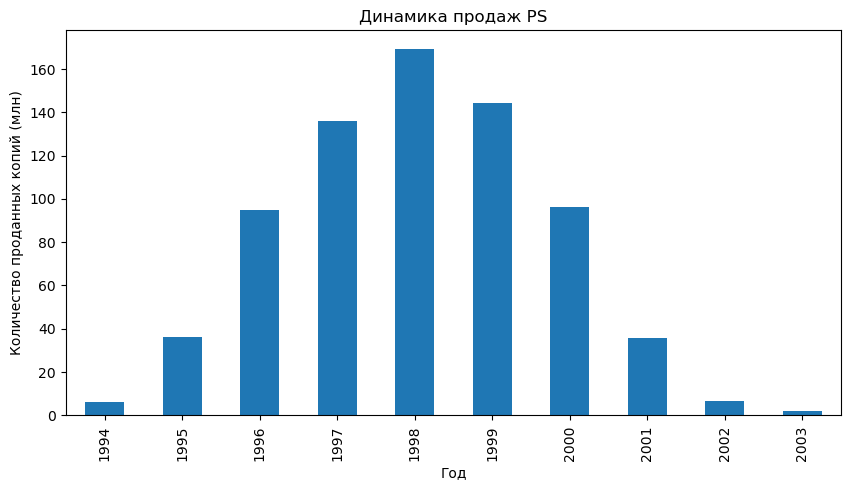

In [26]:
platforms_distribution.loc['PS'].plot('year_of_release',
                                       kind = 'bar',
                                       figsize=(10, 5),
                                       legend=None)
plt.title('Динамика продаж PS')
plt.xlabel('Год')
plt.ylabel('Количество проданных копий (млн)')
plt.show()

**Наблюдения**
* Жизненный цикл для всех рассмтренных платформ составляет около 10-ти лет
* Самые большая популярность находится примерно в середине диапазона на отметке около 5-ти лет

#### Выбор актуального периода для анализа

Графики наглядно показывают, что жизненный цикл косолей составялет около 10 лет, с пиком на 5-6 году жизни. Следовательно, для анализа мы возьмём данные с 2012 по 2016 год — последние 5 лет. Они покажут, на каком жизненном этапе находится консоль: рост или падение.

Отфильтруем датасет по году, начиная с 2012:

In [27]:
last_data = data.loc[data['year_of_release'] >= 2012]
print('Количество платформ за выбранный период:', len(last_data['platform'].unique()))

Количество платформ за выбранный период: 11


In [28]:
print('Cписок платформ:', list(last_data['platform'].unique()))

Cписок платформ: ['PS3', 'X360', 'PS4', '3DS', 'DS', 'XOne', 'WiiU', 'Wii', 'PC', 'PSV', 'PSP']


#### Динамика по выбранному периоду

Построим графики, чтобы отследить динамику:

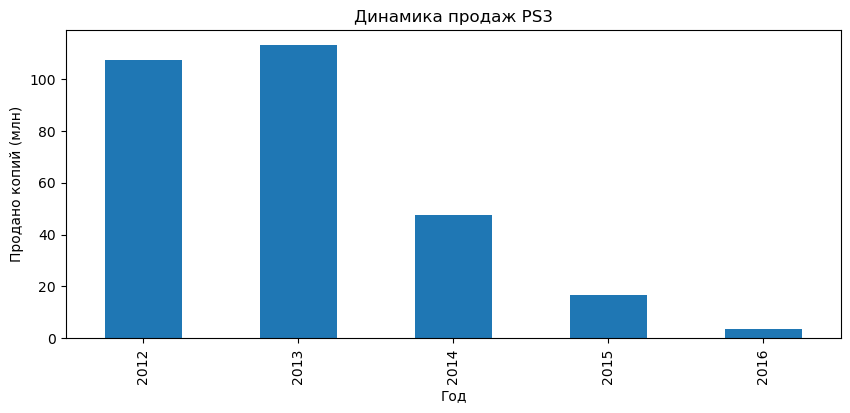

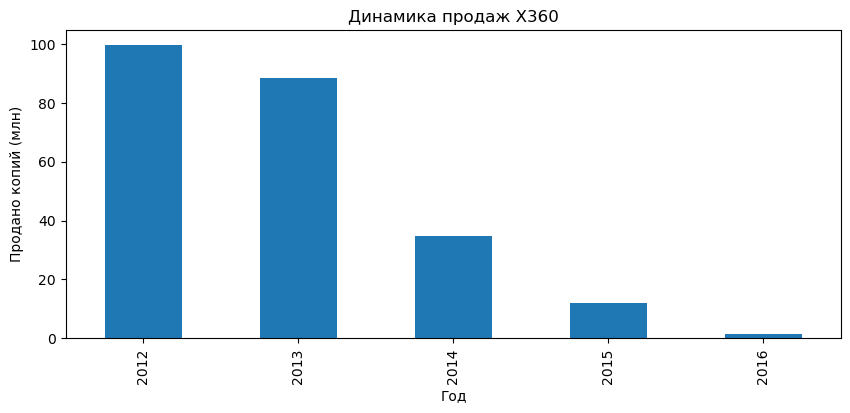

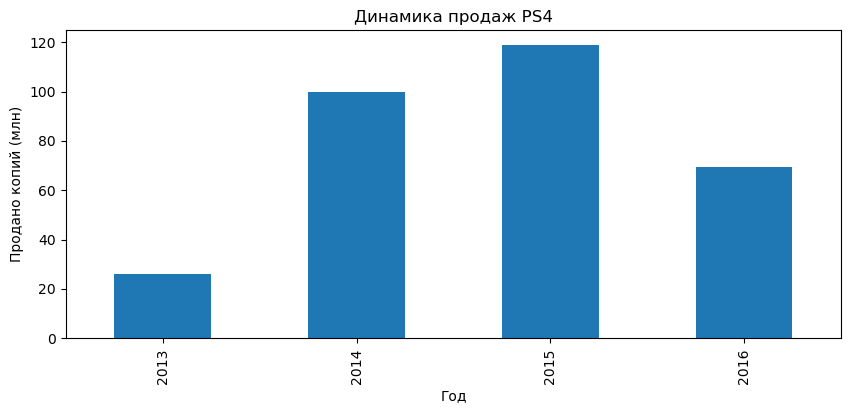

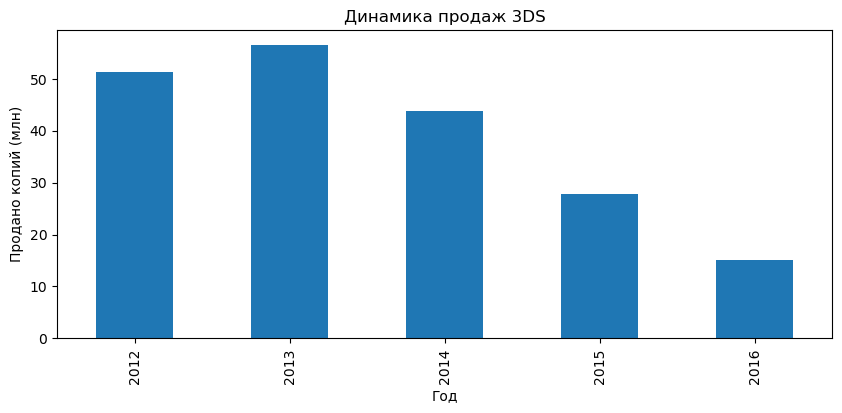

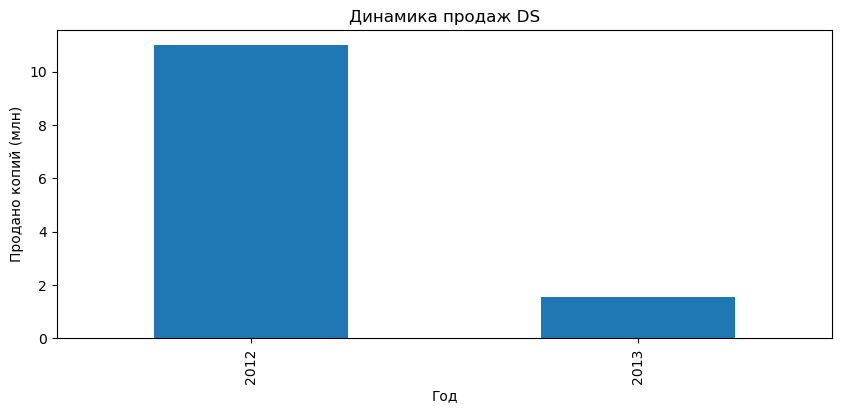

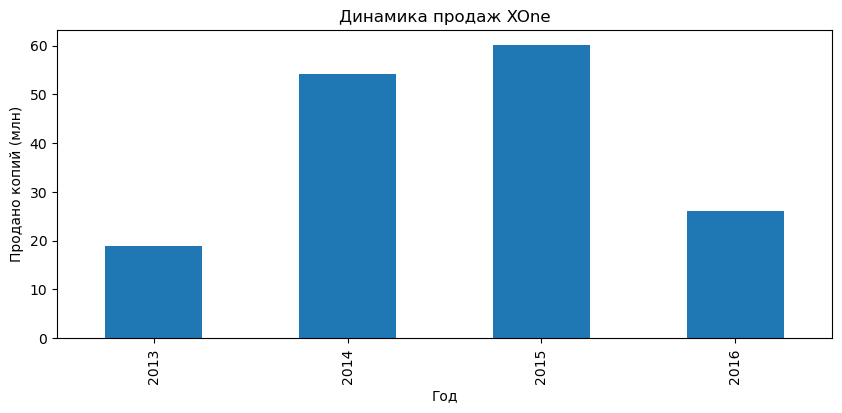

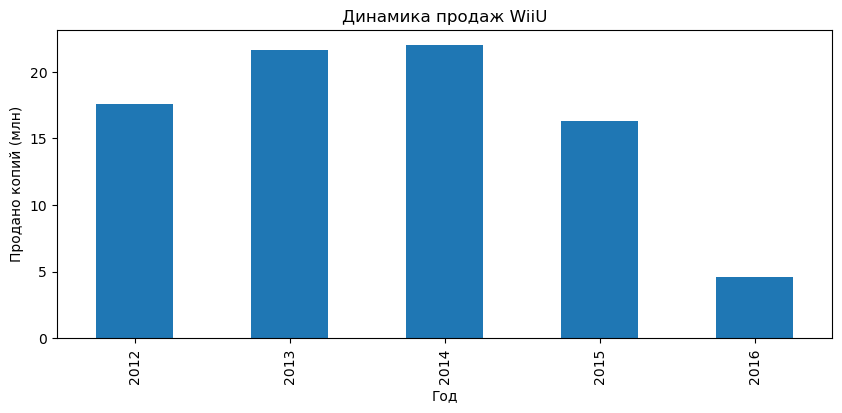

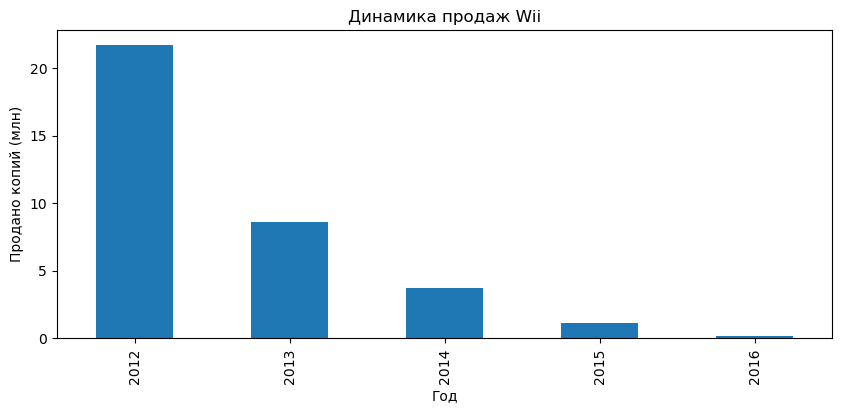

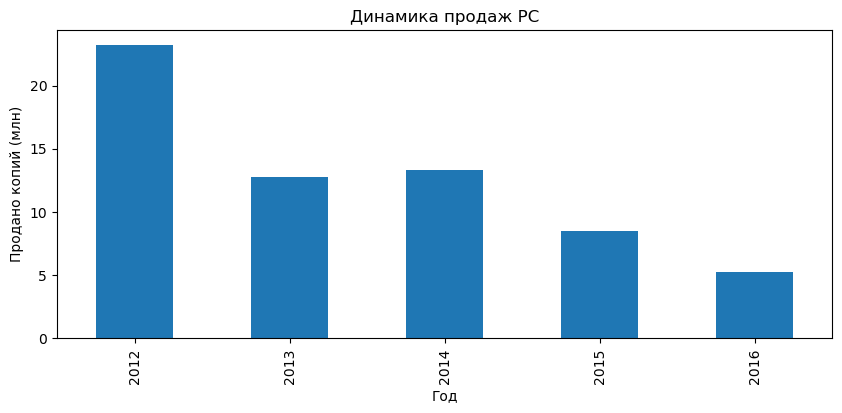

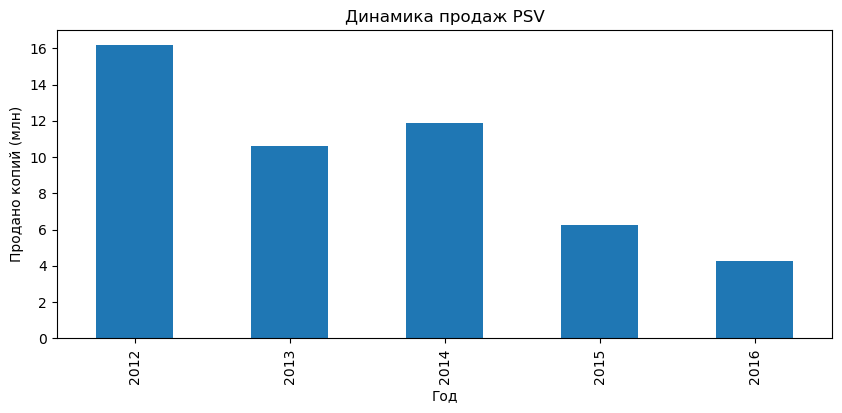

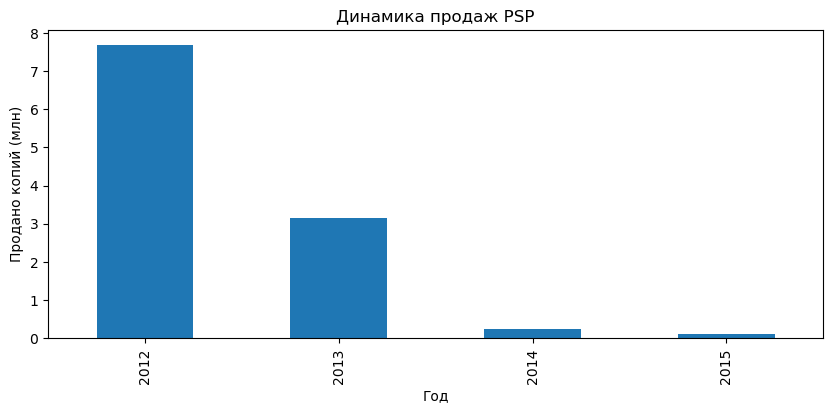

In [29]:
for platform_name in last_data['platform'].unique():
    platform_data = last_data.loc[last_data['platform'] == platform_name].\
    pivot_table(index='year_of_release',
                values='sum_sales',
                aggfunc=np.sum)
    
    platform_data.plot(kind='bar',
                       figsize=(10, 4),
                       legend=None,
                       title = f'Динамика продаж {platform_name}' )
    plt.xlabel('Год')
    plt.ylabel('Продано копий (млн)')
    plt.show()

**Наблюдения**
* Самые высокую популярность в выбранном периоде покзали **PS4, X360 и PS3**
* Самыми молодыми платформами являются **PS4 и XOne** так как их графики начинаются с 2013 года и показывают рост

На пересечении этих двух множеств **PS4** является **потенциально прибыльной**, так как она ещё не дошла до своего 5-летнего пика, при этом у неё один из самых высоких показателей продаж.

#### «Ящик с усами» по глобальным продажам игр

Рассмотрим 4 платформы, которые выделили на предыдущем шаге: **PS3, PS4, X360 и XOne.**  Построим диаграмму с разбивокй по каждой: 

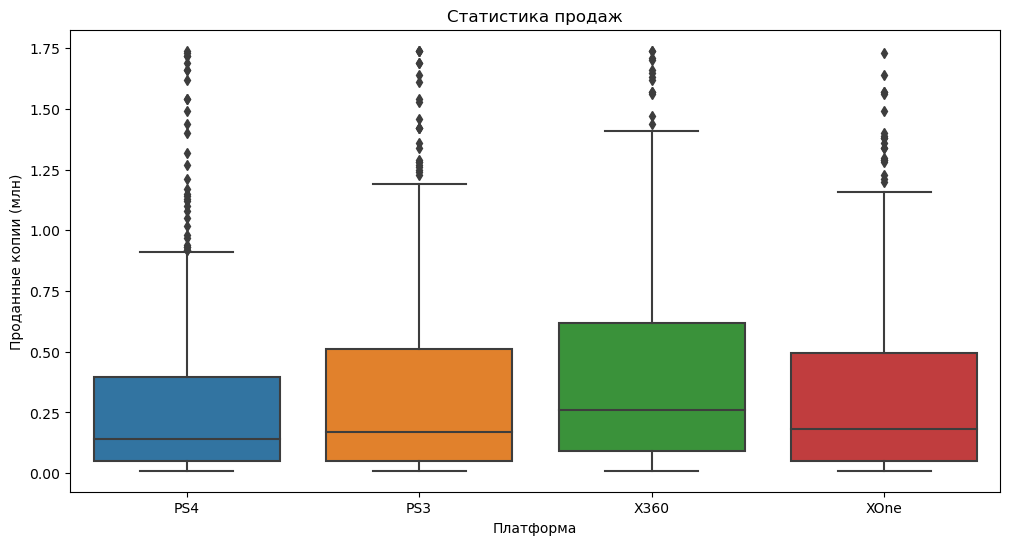

In [30]:
platforms_top4_list = ['PS3', 'PS4', 'X360', 'XOne']

plot_data = last_data[(last_data['platform'].isin(platforms_top4_list)) & (last_data['sum_sales'] < 1.75)]
                      
plt.figure(figsize=(12,6))
sns.boxplot(data=plot_data, x='platform', y='sum_sales')

plt.title('Статистика продаж')
plt.xlabel('Платформа')
plt.ylabel('Проданные копии (млн)')
plt.show()

### Влияние отзывов на показатели продаж

Отфильтруем данные, чтобы избавиться от наблюдений, где стоят `-1` в оценках критиков и пользователей:

In [31]:
last_data = last_data.loc[
    (last_data['critic_score'] != -1) &\
    (last_data['user_score'] != -1.0)]

Проверим, как связаны между собой отзывы пользователей и продажи для **PS4.** Посчитаем коэффициент корреляции:

In [32]:
ps4_df = last_data.loc[(last_data['platform'] == 'PS4')] 
ps4_df['user_score'].corr(ps4_df['sum_sales'])

-0.03362497596528878

Коэффициент близок к нулю, что говорит об очень низкой зависимости.

Проверим теперь связь оценки критиков и продаж:

In [33]:
ps4_df['critic_score'].corr(ps4_df['sum_sales'])

0.40589480145836687

Здесь уже начинает наблюдаться умеренная корреляция: чем выше оценка критиков, тем выше продажи.

Построим диаграмму рассеяния:

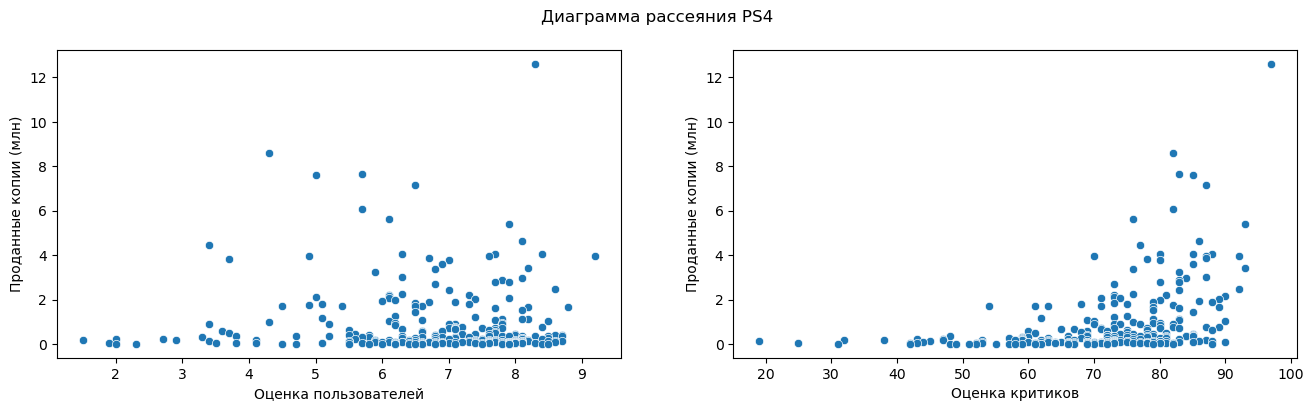

In [34]:
fig, ax = plt.subplots(1 ,2, figsize=(16,4))

sns.scatterplot(x='user_score', y='sum_sales', data=ps4_df, ax=ax[0])
sns.scatterplot(x='critic_score', y='sum_sales', data=ps4_df, ax=ax[1])
fig.suptitle('Диаграмма рассеяния PS4')

ax[0].set(xlabel='Оценка пользователей')
ax[1].set(xlabel='Оценка критиков')
ax[0].set(ylabel='Проданные копии (млн)')
ax[1].set(ylabel='Проданные копии (млн)')
plt.show()

**Наблюдения**
* На примере **PS4** оценка кореллирует с глобальными продами больше, чем  оценка пользователей.

Построим диаграммы и проверим корреляцию для оставшихся трёх платформ:

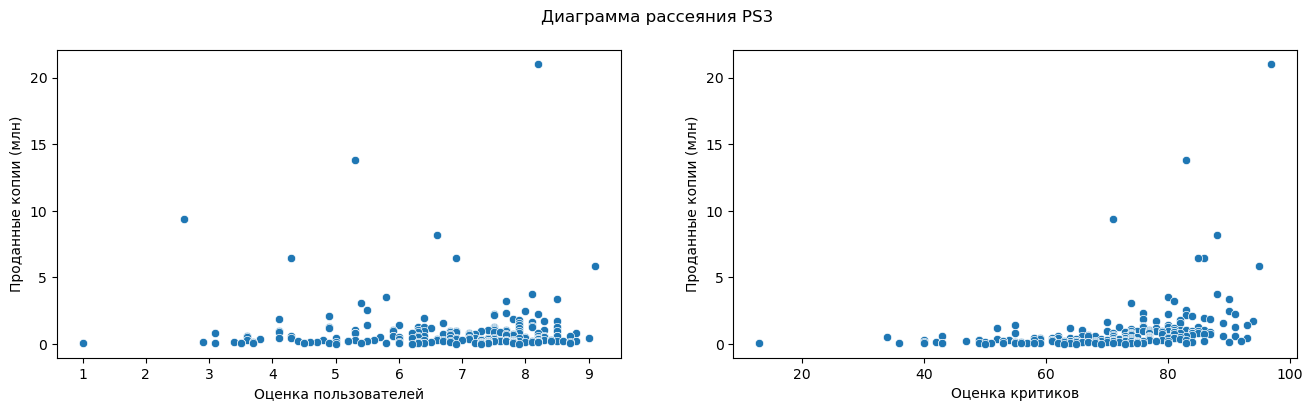

Коррелляция с оценкой пользователе: 0.001
Коррелляция с оценкой критиков: 0.334


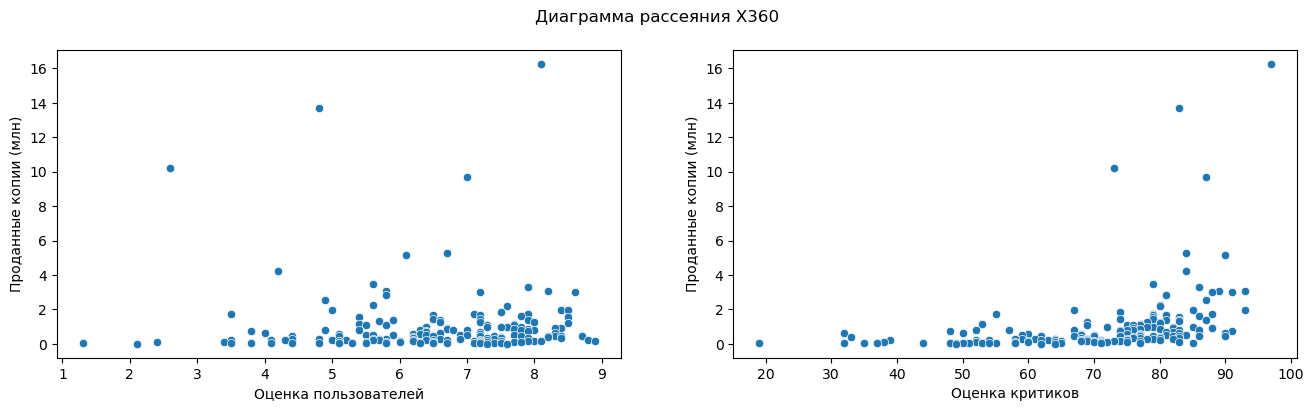

Коррелляция с оценкой пользователе: -0.002
Коррелляция с оценкой критиков: 0.361


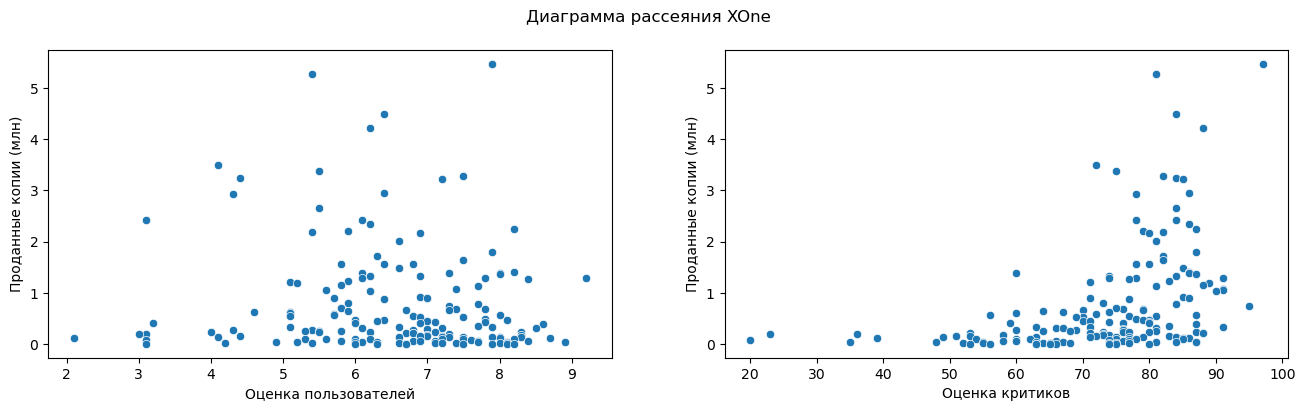

Коррелляция с оценкой пользователе: -0.094
Коррелляция с оценкой критиков: 0.41


In [35]:
for platform_name in ['PS3', 'X360', 'XOne']:
    platform_df = last_data.loc[(last_data['platform'] == platform_name)]
    
    # Визуализация
    fig, ax = plt.subplots(1 ,2, figsize=(16, 4))
    sns.scatterplot(x='user_score', y='sum_sales', data=platform_df, ax=ax[0])
    sns.scatterplot(x='critic_score', y='sum_sales', data=platform_df, ax=ax[1])
    fig.suptitle(f'Диаграмма рассеяния {platform_name}')
    ax[0].set(xlabel='Оценка пользователей')
    ax[1].set(xlabel='Оценка критиков')
    ax[0].set(ylabel='Проданные копии (млн)')
    ax[1].set(ylabel='Проданные копии (млн)')
    plt.show()
    
    # Корелляция
    print('Коррелляция с оценкой пользователе:', round(platform_df['user_score'].corr(platform_df['sum_sales']), 3))
    print('Коррелляция с оценкой критиков:', round(platform_df['critic_score'].corr(platform_df['sum_sales']), 3))
    

**Наблюдения**

Предыдущие предположения подтверждаются:
* Корелляция между оценкой пользователей и продажами практически нулевая
* Корелляция между оценкой критиков и продажами положительная и умеренная

### Распределение игр по жанрам


Соберём таблицу из жанров и суммарных продаж по каждому из них:

In [36]:
genre_by_sales = last_data.pivot_table(index='genre',
                                       values='sum_sales',
                                       aggfunc='sum').\
sort_values(by='sum_sales', ascending=False)
genre_by_sales = genre_by_sales.reset_index()

print(f'Всего {genre_by_sales.genre.count()} жанров')
genre_by_sales.head(genre_by_sales.genre.count())

Всего 12 жанров


,genre,sum_sales
0,Action,330.19
1,Shooter,241.64
2,Sports,140.07
3,Role-Playing,91.80
4,Platform,49.39
5,Racing,41.56
6,Misc,37.91
7,Fighting,26.28
8,Simulation,24.75
9,Adventure,11.70


Визуализируем полученные данные:

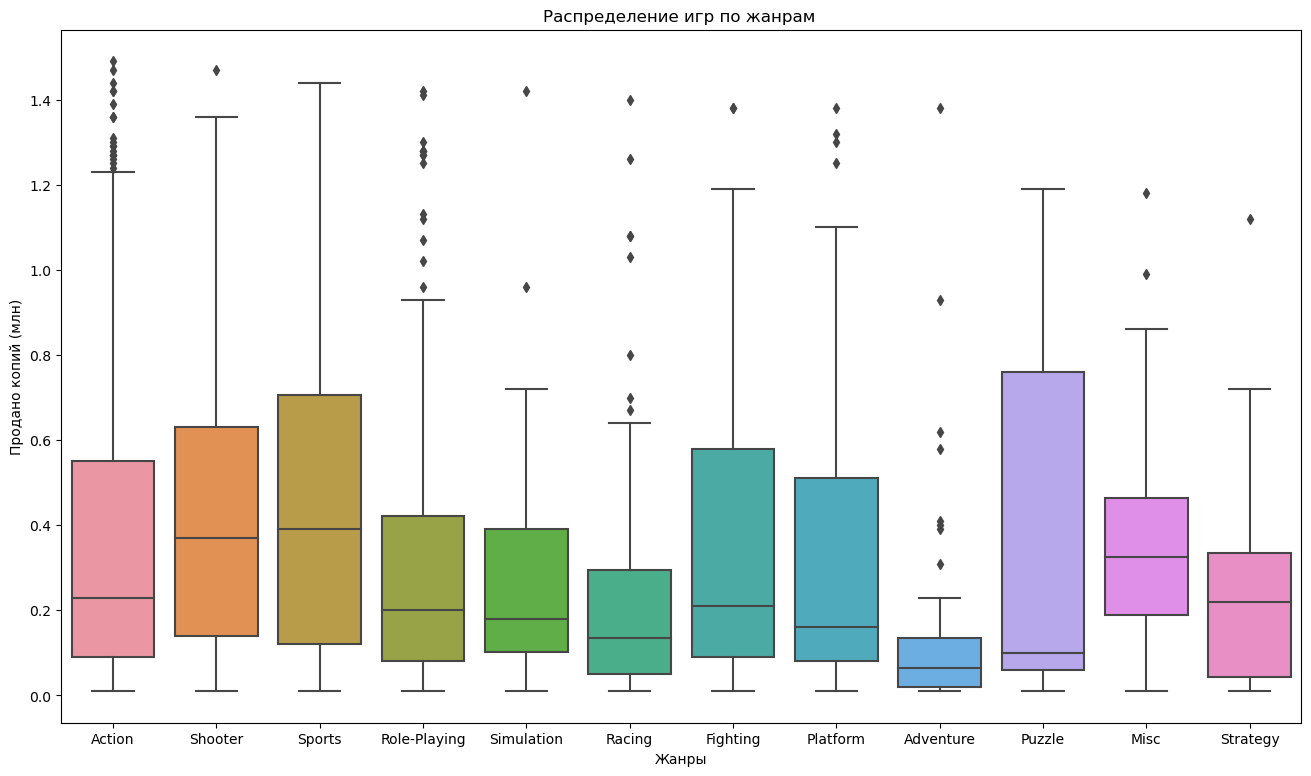

In [37]:
genre_by_sales = last_data[last_data['sum_sales'] < 1.5]
plt.figure(figsize=(16, 9))

sns.boxplot(data=genre_by_sales,
            x='genre',
            y='sum_sales')

plt.title('Распределение игр по жанрам ')
plt.xlabel('Жанры')
plt.ylabel('Продано копий (млн)')
plt.show()

**Наблюдения**
* Самые высокие медианные значения у жанра Shooter, а на последнем месте жанр Adventure

## Портреты пользователей

Определим несколько важных параметров для пользователей каждого региона (NA, EU, JP).

Напишем функцию для создания списков ТОП-5:

In [38]:
# Берём категорию, по которой группируем, и регион (NA, EU, JP), в котором считаем суммарные продажи
def top5(category, region):         
    top5_platforms = last_data.pivot_table(index=category, 
                                      values=f'{region.lower()}_sales',
                                      aggfunc='sum').\
    sort_values(by=f'{region.lower()}_sales', ascending=False)
    top5_platforms = top5_platforms.reset_index().iloc[:5]
    
    return top5_platforms

Добавим функцию для визуализации ТОП-5:

In [39]:
def plot_sales(category, region):
    plt.figure(figsize=(8, 5))
    sns.barplot(data=top5(category, region), x=category, y=f'{region.lower()}_sales')

    plt.title('Регион ' + region)
    if category == 'platform':
        plt.xlabel('Платформа')
    elif category == 'genre':
        plt.xlabel('Жанр')
    elif category == 'rating':
        plt.xlabel('Рейтинг ESRB')
    plt.ylabel('Продано копий (млн)')
    plt.show()

### Самые популярные платформы по регионам

#### Регион NA

Посмотрим на ТОП-5 платформ в Северной Америке:

,platform,na_sales
0,X360,106.99
1,PS4,84.46
2,PS3,77.11
3,XOne,76.03
4,WiiU,30.69


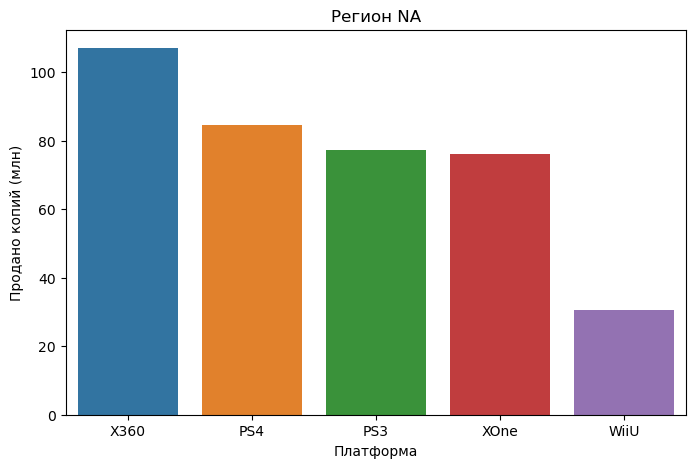

In [40]:
display(top5('platform', 'NA').head())
plot_sales('platform', 'NA')

#### Регион EU

,platform,eu_sales
0,PS4,112.44
1,PS3,78.49
2,X360,57.15
3,XOne,42.23
4,PC,33.96


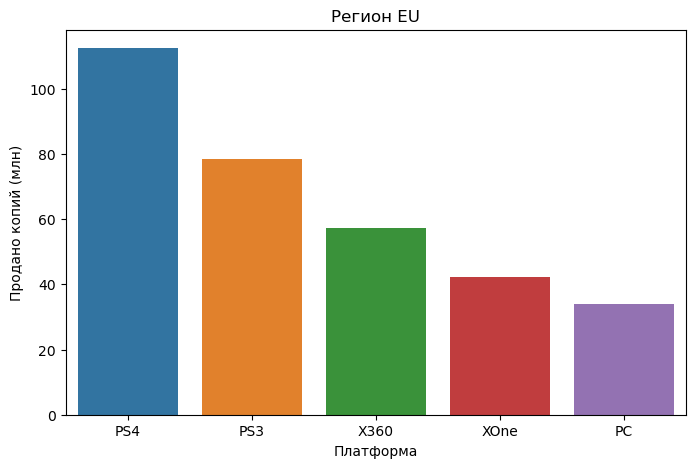

In [41]:
display(top5('platform', 'EU').head())
plot_sales('platform', 'EU')

####  Регион JP

,platform,jp_sales
0,3DS,26.54
1,PS3,20.38
2,WiiU,10.17
3,PS4,9.43
4,PSV,7.05


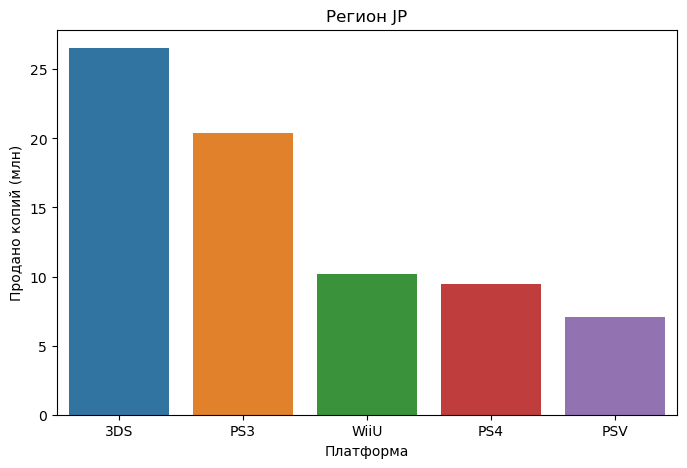

In [42]:
display(top5('platform', 'JP').head())
plot_sales('platform', 'JP')

**Наблюдения**

В каждом ргионе лидеры по продажам отличаются:
* В Северной америке лидирует X360
* В Европе — PS4
* В Японии — 3DS

### Самые популярные жанры по регионам

#### Регион NA

Анализ проведём аналогичным образом. Рассчитаем и визуализируем данные с помощью готовых функций:

,genre,na_sales
0,Action,139.90
1,Shooter,115.75
2,Sports,65.83
3,Role-Playing,36.76
4,Platform,20.39


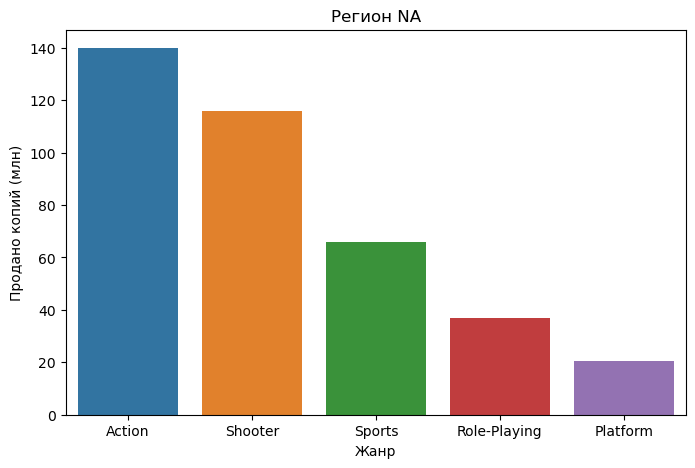

In [43]:
display(top5('genre', 'NA').head())
plot_sales('genre', 'NA')

####  Регион EU

,genre,eu_sales
0,Action,128.06
1,Shooter,89.26
2,Sports,53.81
3,Role-Playing,28.34
4,Racing,20.84


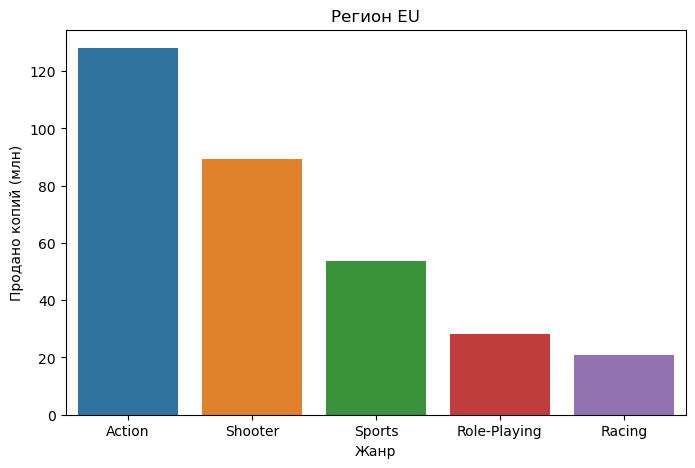

In [44]:
display(top5('genre', 'EU').head())
plot_sales('genre', 'EU')

#### Регион JP

,genre,jp_sales
0,Action,20.92
1,Role-Playing,17.52
2,Platform,7.96
3,Shooter,7.62
4,Simulation,7.29


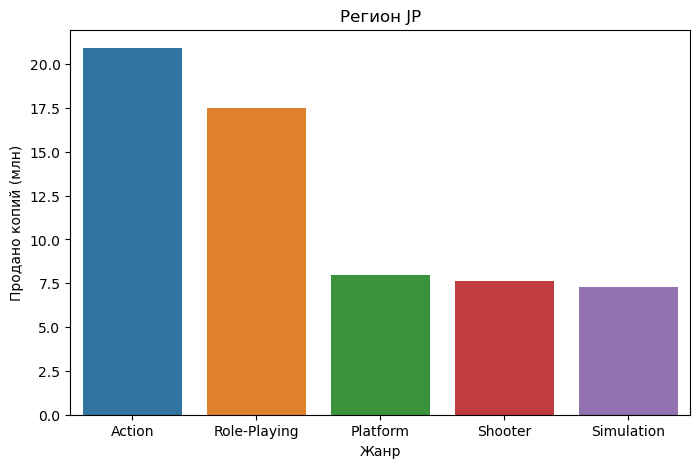

In [45]:
display(top5('genre', 'JP').head())
plot_sales('genre', 'JP')

**Наблюдения**
* Во всех трёх регионах лидирует жанр Action

###  Влияние рейтинга ESRB

Проверим, какие типы рейтинга присутствуют в данных:

In [46]:
list(last_data.rating.unique())

['M', 'E', 'E10+', 'T', 'unknown']

Расчёт и визуализацию проведём аналогично предыдущему этапу.

#### Регион NA

,rating,na_sales
0,M,217.73
1,E,99.19
2,T,61.32
3,E10+,58.40
4,unknown,1.06


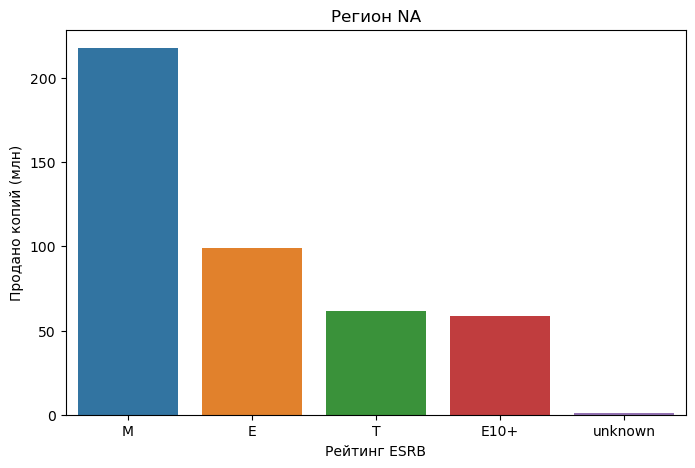

In [47]:
display(top5('rating', 'NA').head())
plot_sales('rating', 'NA')

####  Регион EU

,rating,eu_sales
0,M,184.07
1,E,97.44
2,T,49.86
3,E10+,41.46
4,unknown,3.41


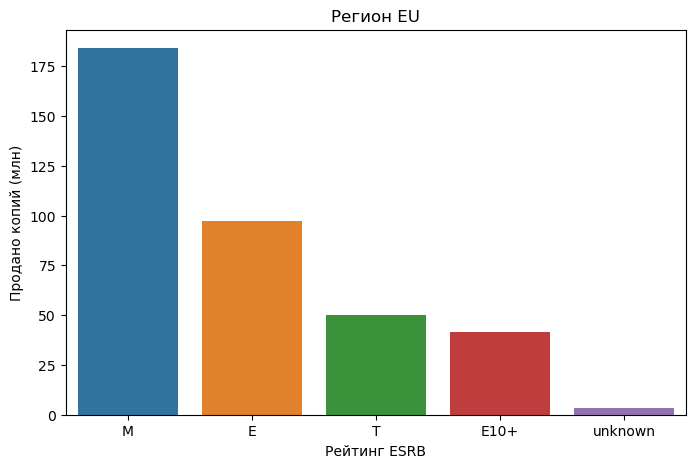

In [48]:
display(top5('rating', 'EU').head())
plot_sales('rating', 'EU')

####  Регион JP

,rating,jp_sales
0,E,26.79
1,T,21.86
2,M,20.02
3,E10+,7.95
4,unknown,0.23


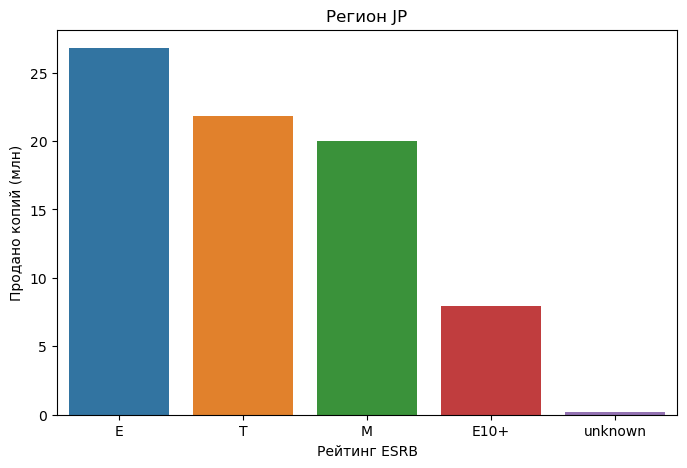

In [49]:
display(top5('rating', 'JP').head())
plot_sales('rating', 'JP')

**Наблюдения**
* В Северной Америке и Европе лидирут игры с рейтингом М
* В Японии самыми популярными являются игры с неизвестным рейтингом ESRB, который предназначен для маркировки игр для США и Канады. Из игр, у которых он известен, лидируют игры с рейтингом E.

## Проверка гипотез

### Гипотеза №1 — «Средние пользовательские рейтинги платформ Xbox One и PC одинаковые»

Так как в гипотезе присутствует слово «одинаковые», примем, что:
* **H0** — средний пользовательский рейтинг (СПР) Xbox One ***равен*** СПР PC
* **H1** — СПР Xbox One ***не равен*** СПР PC

Подготовим данные для t-теста:

In [50]:
last_data = last_data[last_data['user_score'] != -1]

In [51]:
xo_sample = last_data.loc[last_data['platform'] == 'XOne']['user_score'].values
pc_sample = last_data.loc[last_data['platform'] == 'PC']['user_score'].values

Проверим размеры семплов:

In [52]:
print(f'Xbox One: {len(xo_sample)} \nPC: {len(pc_sample)}')

Xbox One: 165 
PC: 198


* Количество значений различается, поэтому параметр `equal_var=False`. 
* Так как в H1 содержится словосочетание ***не равен***, параметер `alternative='two-sided'`

In [53]:
alpha = .05

results = st.ttest_ind(
    xo_sample,
    pc_sample,
    equal_var=False,
    alternative='two-sided')
print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value: 0.638780576924092
Не отвергаем нулевую гипотезу


**Вывод**
* Нет оснований опровергать гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые

### Гипотеза №2 — «Средние пользовательские рейтинги жанров Action и Sports разные»

Так как в формулирове гипотезы присутствует слово «разные», то она встанет на место альтернативной. Примем, что:

* **H0** — Средние пользовательские рейтинги жанров Action и Sports ***равны***
* **H1** — Средние пользовательские рейтинги жанров Action и Sports ***не равны***

Подготовим данные для t-теста:

In [54]:
action_sample = last_data.loc[last_data['genre'] == 'Action']['user_score'].values
sports_sample = last_data.loc[last_data['genre'] == 'Sports']['user_score'].values

print(f'Action: {len(action_sample)} \nSports: {len(sports_sample)}')

Action: 433 
Sports: 140


Вновь получаем:

* Количество значений различается, поэтому параметр `equal_var=False`.
* Так как в H1 содержится словосочетание ***не равен***, параметер `alternative='two-sided'`

In [55]:
alpha = .05

results = st.ttest_ind(
    action_sample,
    sports_sample,
    equal_var=False,
    alternative='two-sided')
print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-value: 7.474987972417277e-14
Отвергаем нулевую гипотезу


**Вывод**
* Так как нулевая гипотеза опроверглась, у нас нет оснований опровергать исходную гипотезу, что средние пользовательские рейтинги жанров Action и Sports разные.

Сравним средние значения для каждой пары выборок:

In [56]:
print(f'Средние значения по платформам \nXbox One {xo_sample.mean()}\nPC {pc_sample.mean()}\n')
print(f'Средние значения по жанрам: \nAction {action_sample.mean()}\nSports {sports_sample.mean()}')

Средние значения по платформам 
Xbox One 6.538181818181818
PC 6.4646464646464645

Средние значения по жанрам: 
Action 6.903002309468822
Sports 5.822142857142857


Так как средние значения по платформам близки, а по жанрам различны, это подтверждает наши выводы по проверенным гипотезам.

---

## Финальные выводы
В ходе исследования мы проанализирован датасет с историческими данными о продажах игр, жанрах, оценках пользователей и экспертов, и платформах, на которых эти игры были выпущены.

На каждом из этапов мы сделали наблюдения и выявили некоторые закономерности.

### Cтатистика выпуска игр

Всю динамику продаж можно разделить на 3 ключевых этапа:
1. **1980–1990** — стабильно низкий уровень выпуска
2. **1991—2008** — восходящий тренд c пиком в 2007 году
3. **2009—2016** — нисходящий тренд
--- 
*Это может означать что в следующем 2017 году не будет резкого роста на рынке видеоигр.*

### Изменение продаж по платформам
* Жизненный цикл платформ составляет около 10-ти лет
* Чаще пик популярности находится примерно в середине диапазона
* Диапазон в 5 лет был выбран оптимальным периодом для анализа

В период с 2102 по 2016 годы:
* Самые высокие продажи по всем регионам покзали **PS4, X360 и PS3**
* **PS4** является **потенциально прибыльной** 
    * Она ещё не дошла до своего 5-летнего пика
    * У неё один из самых высоких показателей продаж

### Влияние отзывов на показатели продаж
* Корелляция между оценкой пользователей и продажами практически нулевая
* Корелляция между оценкой критиков и продажами положительная и умеренная
---
*Это может означать, что чем выше оценка критиков, тем вероятнее у выпущенной игры будет высокая популярность.*

### Портреты пользователей

По **платформам** в каждом регионе лидеры отличаются:

* В Северной америке лидирует X360
* В Европе — PS4
* В Японии — 3DS

**Жанр Action** во всех трёх регионах является самым популярным.

По **рейтинге ESRB**
* В Северной Америке и Европе лидирут игры со значением **М**
* В Японии самыми популярными являются игры со значением **E**
---
*Эти наблюдения могут быть полезны при выборе платформы и жанра для разработки будущей игры, расчитанной на популярность в конкретном регионе.*

### Проверка гипотез
**Гипотеза №1**
* «Средние пользовательские рейтинги платформ Xbox One и PC одинаковые» — **не опроверглась.**

**Гипотеза №2**  
* «Средние пользовательские рейтинги жанров Action и Sports разные» — **не опроверглась.**
